In [1]:
# Dependencies
%matplotlib inline

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from math import sqrt

In [2]:
# Read Housing Price Training Data
training_df = pd.read_csv("MLResources/realestate_all_train.csv")
training_df.head()
training_df.count()

County    1188
State     1188
Year      1188
Price     1143
dtype: int64

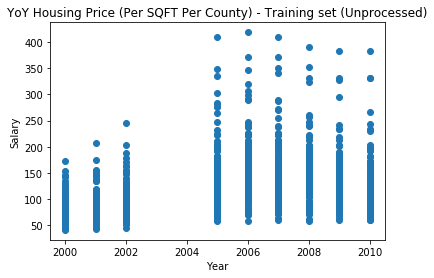

In [3]:
# Plot Training Data - YoY Price of All Counties 
plt.plot(training_df['Year'], training_df['Price'],'o')
plt.title('YoY Housing Price (Per SQFT Per County) - Training set (Unprocessed)')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.show()

In [4]:
# plt.hist(training_df['Price'], 2000)
# plt.show()

In [5]:
# Handle missing data
missing_df = training_df.loc[training_df['Year'].isin(['2003','2004'])]
missing_df.head()  

,County,State,Year,Price


In [6]:
# Backfill missing data for 2003 and 2004 from 2002 and 2005 
backfill_2002_df = training_df.loc[training_df['Year'].isin(['2002'])]
backfill_2005_df = training_df.loc[training_df['Year'].isin(['2005'])]
backfill_2002_df = backfill_2002_df.dropna()
backfill_2005_df = backfill_2005_df.dropna()
backfill_2002_df.count()
backfill_2005_df.count()

County    128
State     128
Year      128
Price     128
dtype: int64

In [7]:
backfill_df = backfill_2002_df.merge(backfill_2005_df, on=['County','State'], how='inner')
backfill_df.head()
# backfill_df.count()

,County,State,Year_x,Price_x,Year_y,Price_y
0,King County,WA,2002,154.750000,2005,202.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000
2,Montgomery County,MD,2002,170.083333,2005,282.000000
3,Prince Georges County,MD,2002,108.583333,2005,194.166667
4,Baltimore County,MD,2002,99.250000,2005,163.666667


In [8]:
backfill_df['Diff_Price'] = backfill_df['Price_y'] - backfill_df['Price_x']
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667


In [9]:
backfill_df['2003_Price'] = backfill_df['Diff_Price']/3 + backfill_df['Price_x']
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price,2003_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000,170.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667,219.972222
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667,207.388889
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333,137.111111
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667,120.722222


In [10]:
backfill_df['2004_Price'] = backfill_df['Price_y'] - backfill_df['Diff_Price']/3 
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price,2003_Price,2004_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000,170.750000,186.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667,219.972222,261.361111
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667,207.388889,244.694444
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333,137.111111,165.638889
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667,120.722222,142.194444


In [11]:
backfill_2003 = backfill_df.loc[:, ['County','State','Year','2003_Price']]
backfill_2003['Year'] = 2003
backfill_2003 = backfill_2003.rename(columns = {'2003_Price': 'Price'})
backfill_2003.head()

/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,County,State,Year,Price
0,King County,WA,2003,170.750000
1,Fairfax County,VA,2003,219.972222
2,Montgomery County,MD,2003,207.388889
3,Prince Georges County,MD,2003,137.111111
4,Baltimore County,MD,2003,120.722222


In [12]:
backfill_2004 = backfill_df.loc[:, ['County','State','Year','2004_Price']]
backfill_2004['Year'] = 2004
backfill_2004 = backfill_2004.rename(columns = {'2004_Price': 'Price'})
backfill_2004.head()

,County,State,Year,Price
0,King County,WA,2004,186.750000
1,Fairfax County,VA,2004,261.361111
2,Montgomery County,MD,2004,244.694444
3,Prince Georges County,MD,2004,165.638889
4,Baltimore County,MD,2004,142.194444


In [13]:
training_df = training_df.append(backfill_2003, ignore_index=True)
training_df = training_df.append(backfill_2004, ignore_index=True)
training_df.head()

,County,State,Year,Price
0,King County,WA,2000,141.166667
1,Fairfax County,VA,2000,134.000000
2,Montgomery County,MD,2000,126.916667
3,Prince Georges County,MD,2000,91.833333
4,Baltimore County,MD,2000,86.750000


In [14]:
print(training_df.loc[training_df['Price'].isin(['NaN'])].count())

County    45
State     45
Year      45
Price      0
dtype: int64


In [15]:
training_dfdum = training_df.dropna()
training_dfdum.head()
training_dfdum.count()

County    1391
State     1391
Year      1391
Price     1391
dtype: int64

In [16]:
print(training_dfdum.loc[training_dfdum['Price'].isin(['NaN'])])

Empty DataFrame
Columns: [County, State, Year, Price]
Index: []


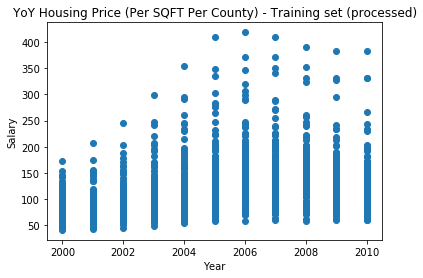

In [17]:
# Plot Training Data After Handling Missig Data - YoY Price of All Counties 
plt.plot(training_df['Year'], training_df['Price'],'o')
plt.title('YoY Housing Price (Per SQFT Per County) - Training set (processed)')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.show()

In [18]:
# Encode Categorical Features - County and State
cat_features = ['County','State']
num_features = ['Price','Year']

categories = cat_features[0:len(cat_features)]

for category in categories:
    series = training_dfdum[category]
    dummies = pd.get_dummies(series, prefix=category)
    training_dfdum = pd.concat([training_dfdum, dummies], axis=1)
    
print(training_dfdum.columns)
training_dfdum.head()
training_dfdum.count()

Index(['County', 'State', 'Year', 'Price', 'County_Adams County',
       'County_Allegany County', 'County_Alleghany County',
       'County_Amherst County', 'County_Anne Arundel County',
       'County_Arlington County',
       ...
       'County_Wicomico County', 'County_Williamsburg City',
       'County_Winchester City', 'County_Worcester County',
       'County_Yakima County', 'County_York County', 'State_DC', 'State_MD',
       'State_VA', 'State_WA'],
      dtype='object', length=134)


County                         1391
State                          1391
Year                           1391
Price                          1391
County_Adams County            1391
County_Allegany County         1391
County_Alleghany County        1391
County_Amherst County          1391
County_Anne Arundel County     1391
County_Arlington County        1391
County_Asotin County           1391
County_Augusta County          1391
County_Baltimore City          1391
County_Baltimore County        1391
County_Bedford County          1391
County_Benton County           1391
County_Botetourt County        1391
County_Bristol City            1391
County_Calvert County          1391
County_Caroline County         1391
County_Carroll County          1391
County_Cecil County            1391
County_Charles County          1391
County_Charlottesville City    1391
County_Chelan County           1391
County_Chesapeake City         1391
County_Chesterfield County     1391
County_Clallam County       

In [19]:
# Feature Scaling (remove features not encoded) 
removefeats= ["County","State","Price"]

# standardScalerX = StandardScaler()
# x = standardScalerX.fit_transform(training_dfdum.drop(removefeats, axis=1))
# x

In [20]:
# Create & Fit Linear Regression Model 
# X_train = x
X_train = training_dfdum.drop(removefeats, axis=1)
y_train = training_dfdum['Price']

regr = linear_model.LinearRegression()

lr_model = regr.fit(X_train, y_train)


In [21]:
# Predict Training Data
y_train_predict = lr_model.predict(X_train)
print(f"True output: {y_train[0]}")
print(f"Predicted output: {y_train_predict[0]}")
print(f"Prediction Error: {y_train_predict[0]-y_train[0]}")

True output: 141.16666666666666
Predicted output: 160.34375
Prediction Error: 19.177083333333343


In [22]:
print(f"True output: {y_train[2]}")
print(f"Predicted output: {y_train_predict[2]}")
print(f"Prediction Error: {y_train_predict[2]-y_train[2]}")

True output: 126.91666666666669
Predicted output: 150.296875
Prediction Error: 23.380208333333314


In [23]:
# R2 Score
score = lr_model.score(X_train, y_train)
print(f"R2 Score: {score}")

R2 Score: 0.824568509114207


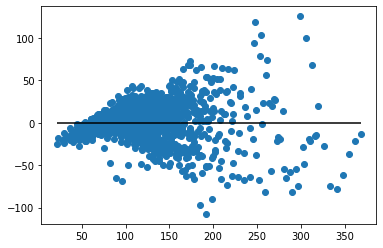

In [24]:
# Plot Residuals
plt.scatter(y_train_predict, y_train_predict - y_train)
plt.hlines(y=0, xmin=y_train_predict.min(), xmax=y_train_predict.max())
plt.show()

In [25]:
# Read Housing Price Testing Data
testing_df = pd.read_csv("MLResources/realestate_all_test.csv")
testing_df.head()
testing_df.count()

County    1056
State     1056
Year      1056
Price     1056
dtype: int64

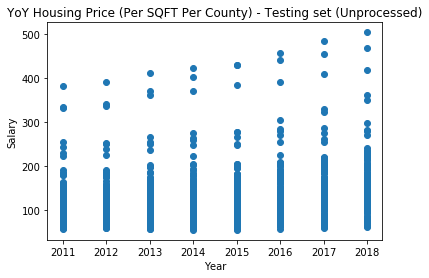

In [26]:
# Plot Testing Data - YoY Price of All Counties 
plt.plot(testing_df['Year'], testing_df['Price'],'o')
plt.title('YoY Housing Price (Per SQFT Per County) - Testing set (Unprocessed)')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.show()

In [27]:
testing_dfdum = testing_df.dropna()
testing_dfdum.head()
testing_dfdum.count()

County    1056
State     1056
Year      1056
Price     1056
dtype: int64

In [28]:
# Encode Categorical Features - County and State
# cat_features = ['County','State']
# num_features = ['Price','Year']

# categories = cat_features[0:len(cat_features)]

for category in categories:
    series = testing_dfdum[category]
    dummies = pd.get_dummies(series, prefix=category)
    testing_dfdum = pd.concat([testing_dfdum, dummies], axis=1)
    
print(testing_dfdum.columns)
testing_dfdum.head()
testing_dfdum.count()

Index(['County', 'State', 'Year', 'Price', 'County_Adams County',
       'County_Allegany County', 'County_Alleghany County',
       'County_Amherst County', 'County_Anne Arundel County',
       'County_Arlington County',
       ...
       'County_Wicomico County', 'County_Williamsburg City',
       'County_Winchester City', 'County_Worcester County',
       'County_Yakima County', 'County_York County', 'State_DC', 'State_MD',
       'State_VA', 'State_WA'],
      dtype='object', length=135)


County                         1056
State                          1056
Year                           1056
Price                          1056
County_Adams County            1056
County_Allegany County         1056
County_Alleghany County        1056
County_Amherst County          1056
County_Anne Arundel County     1056
County_Arlington County        1056
County_Asotin County           1056
County_Augusta County          1056
County_Baltimore City          1056
County_Baltimore County        1056
County_Bedford County          1056
County_Benton County           1056
County_Botetourt County        1056
County_Bristol City            1056
County_Calvert County          1056
County_Caroline County         1056
County_Carroll County          1056
County_Cecil County            1056
County_Charles County          1056
County_Charlottesville City    1056
County_Chelan County           1056
County_Chesapeake City         1056
County_Chesterfield County     1056
County_Clallam County       

In [29]:
# # Get missing columns in the training test
# missing_cols = set( X_train.columns ) - set( X_test.columns )
# # Add a missing column in test set with default value equal to 0
# for c in missing_cols:
#     testing_dfdum[c] = 0
# # Ensure the order of column in the test set is in the same order than in train set
# testing_dfdum = testing_dfdum[training_dfdum.columns]
# testing_dfdum.head()

# Get missing columns in the training set
print(set(testing_dfdum.columns) - set(training_dfdum.columns))

# Drop columns from the testing set
missing_cols = set(testing_dfdum.columns) - set(training_dfdum.columns)
for c in missing_cols:
    testing_dfdum = testing_dfdum.drop(testing_dfdum[c]).reset_index(drop=True)

# Ensure the order of column in the test set is in the same order as in train set
testing_dfdum = testing_dfdum[training_dfdum.columns]
testing_dfdum.count()

{'County_Whitman County'}


County                         1054
State                          1054
Year                           1054
Price                          1054
County_Adams County            1054
County_Allegany County         1054
County_Alleghany County        1054
County_Amherst County          1054
County_Anne Arundel County     1054
County_Arlington County        1054
County_Asotin County           1054
County_Augusta County          1054
County_Baltimore City          1054
County_Baltimore County        1054
County_Bedford County          1054
County_Benton County           1054
County_Botetourt County        1054
County_Bristol City            1054
County_Calvert County          1054
County_Caroline County         1054
County_Carroll County          1054
County_Cecil County            1054
County_Charles County          1054
County_Charlottesville City    1054
County_Chelan County           1054
County_Chesapeake City         1054
County_Chesterfield County     1054
County_Clallam County       

In [30]:
# testing_dfdum = testing_dfdum.reset_index(drop=True)
testing_dfdum.head()

,County,State,Year,Price,County_Adams County,County_Allegany County,County_Alleghany County,County_Amherst County,County_Anne Arundel County,County_Arlington County,...,County_Wicomico County,County_Williamsburg City,County_Winchester City,County_Worcester County,County_Yakima County,County_York County,State_DC,State_MD,State_VA,State_WA
0,Montgomery County,MD,2011,224.166667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Prince Georges County,MD,2011,126.333333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Baltimore County,MD,2011,141.666667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Pierce County,WA,2011,126.750000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Snohomish County,WA,2011,150.333333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
# Feature Scaling (remove features not encoded) 
removefeats= ["County","State","Price"]

# standardScalerX = StandardScaler()
# xtest = standardScalerX.fit_transform(testing_dfdum.drop(removefeats, axis=1))
# xtest
# X_test = xtest

X_test = testing_dfdum.drop(removefeats, axis=1)
y_test = testing_dfdum['Price']


In [32]:
# Remove features not encoded
# removefeats= ["County","State","Price"]

# X_test = testing_dfdum.drop(removefeats, axis=1)
# y_test = testing_dfdum['Price']

In [33]:
# Predict Testing Data
y_test_predict = lr_model.predict(X_test)
print(f"True output: \n{y_test[0]}")
print(f"Predicted output: {y_test_predict[0]}")
print(f"Prediction Error: {y_test_predict[0]-y_test[0]}")

True output: 
224.16666666666663
Predicted output: 227.125
Prediction Error: 2.9583333333333712


In [37]:
print(f"True output: \n{y_test[2]}")
print(f"Predicted output: {y_test_predict[2]}")
print(f"Prediction Error: {y_test_predict[2]-y_test[2]}")

True output: 
141.66666666666666
Predicted output: 185.171875
Prediction Error: 43.50520833333334


In [35]:
score = lr_model.score(X_test, y_test)
print(f"R2 Score: {score}")

R2 Score: -4.21144298333297e+20


In [43]:
print(y_test_predict.min(), y_test_predict.max())
print(y_train_predict.min(), y_train_predict.max())

68.03125 14202069547278.809
21.3125 368.84375


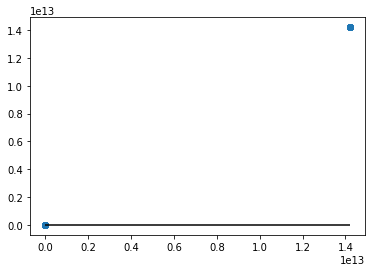

In [36]:
# Plot Residuals
plt.scatter(y_test_predict, y_test_predict - y_test)
plt.hlines(y=0, xmin=y_test_predict.min(), xmax=y_test_predict.max())
plt.show()